# Recommendation Systems with CF and DL Techniques

Based on: [Chinmayrane16's works](https://github.com/Chinmayrane16/Recommender-Systems-with-Collaborative-Filtering-and-Deep-Learning-Techniques/blob/master/Recommendation%20Systems%20with%20CF%20and%20DL%20Techniques.ipynb)

### Importing Libraries

In [1]:
# Ignore warnings :
import warnings
warnings.filterwarnings('ignore')

# Handle table-like data and matrices :
import numpy as np
import pandas as pd
import math 
import itertools
import os

# Modelling Helpers
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import Normalizer, scale
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.feature_selection import RFECV
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score

# Evaluation metrics :

# Regression
from sklearn.metrics import mean_squared_log_error,mean_squared_error, r2_score,mean_absolute_error 
# Classification
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score

# Visualisation
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
import missingno as msno

# Configure visualisations
%matplotlib inline
mpl.style.use( 'ggplot' )
plt.style.use('fivethirtyeight')
sns.set(context="notebook", palette="dark", style = 'whitegrid' , color_codes=True)

In [2]:
# Center all plots
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""");


# Make Visualizations better
params = { 
    'axes.labelsize': "large",
    'xtick.labelsize': 'x-large',
    'legend.fontsize': 20,
    'figure.dpi': 150,
    'figure.figsize': [25, 7]
}
plt.rcParams.update(params)

### Extracting the Dataset

In [3]:
ratings = pd.read_csv('data/ratings.csv')
movies = pd.read_csv('data/movies.csv')

df_r = ratings.copy()
df_m = movies.copy()

### Ratings

In [4]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


As you can see the "ratings" dataframe has 4 columns.

* userId - Every user is represented by an unique Id.
* movieId - Every movie is represented by an uniue Id.
* rating - Represents the rating given by the user to the corresponding movie.
* timestamp - The time at which the rating was recorded.

In [5]:
ratings.shape

(100836, 4)

In [6]:
ratings.describe()

,userId,movieId,rating,timestamp
count,100836.000000,100836.000000,100836.000000,1.008360e+05
mean,326.127564,19435.295718,3.501557,1.205946e+09
std,182.618491,35530.987199,1.042529,2.162610e+08
min,1.000000,1.000000,0.500000,8.281246e+08
25%,177.000000,1199.000000,3.000000,1.019124e+09
50%,325.000000,2991.000000,3.500000,1.186087e+09
75%,477.000000,8122.000000,4.000000,1.435994e+09
max,610.000000,193609.000000,5.000000,1.537799e+09


Some insights that can be drawn are:

1. The minimum rating given to the movie is 0,5 whereas the maximum rating given to the movies is 5.0
2. The average rating that is the mean ratings given by the users to all the movies is 3.5
3. The users have userId's in the range 1 - 610
4. The movies have movieId's in the range 1 - 193609.(Note that 193609 is the highest movieId and not total number of movies).

Here, we will be dropping the timestamp attribute as we are not concerned with when the user rated a particular movie.

In [7]:
ratings.drop(['timestamp'], axis=1, inplace=True)

ratings.head()

,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


### Movies

In [8]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


As you can see the "movies" dataframe has 3 columns:

* movieId - Every movie is represented by an unique Id.
* title - Movie which is represented by the corresponding movieId.
* genres - Represents category of the movie.

In [9]:
print('Shape: ', movies.shape, '\n')

movies.info()

Shape:  (9742, 3) 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


### Combining the Movies and Ratings DataFrame

In [10]:
#  We need to merge on "movieId" attribute since it is common between both the dataframes
df_combined = pd.merge(ratings, movies, on = 'movieId')

df_combined.head()

,userId,movieId,rating,title,genres
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


In [11]:
df_combined.shape

(100836, 5)

# Exploratory Data Analysis

### Visualizations on the Dataset

In [12]:
# Create a function to find genres in the dataset

genres = {} # create a dictionary to store different genre values

def find_genres():
    for genre in movies['genres']:
        words = genre.split('|')
        for word in words:
            genres[word] = genres.get(word, 0) + 1
            
find_genres()

genres

{'Adventure': 1263,
 'Animation': 611,
 'Children': 664,
 'Comedy': 3756,
 'Fantasy': 779,
 'Romance': 1596,
 'Drama': 4361,
 'Action': 1828,
 'Crime': 1199,
 'Thriller': 1894,
 'Horror': 978,
 'Mystery': 573,
 'Sci-Fi': 980,
 'War': 382,
 'Musical': 334,
 'Documentary': 440,
 'IMAX': 158,
 'Western': 167,
 'Film-Noir': 87,
 '(no genres listed)': 34}

In [13]:
# replace '(no genres listed)' by 'None'
genres['None'] = genres.pop('(no genres listed)')

genres

{'Adventure': 1263,
 'Animation': 611,
 'Children': 664,
 'Comedy': 3756,
 'Fantasy': 779,
 'Romance': 1596,
 'Drama': 4361,
 'Action': 1828,
 'Crime': 1199,
 'Thriller': 1894,
 'Horror': 978,
 'Mystery': 573,
 'Sci-Fi': 980,
 'War': 382,
 'Musical': 334,
 'Documentary': 440,
 'IMAX': 158,
 'Western': 167,
 'Film-Noir': 87,
 'None': 34}

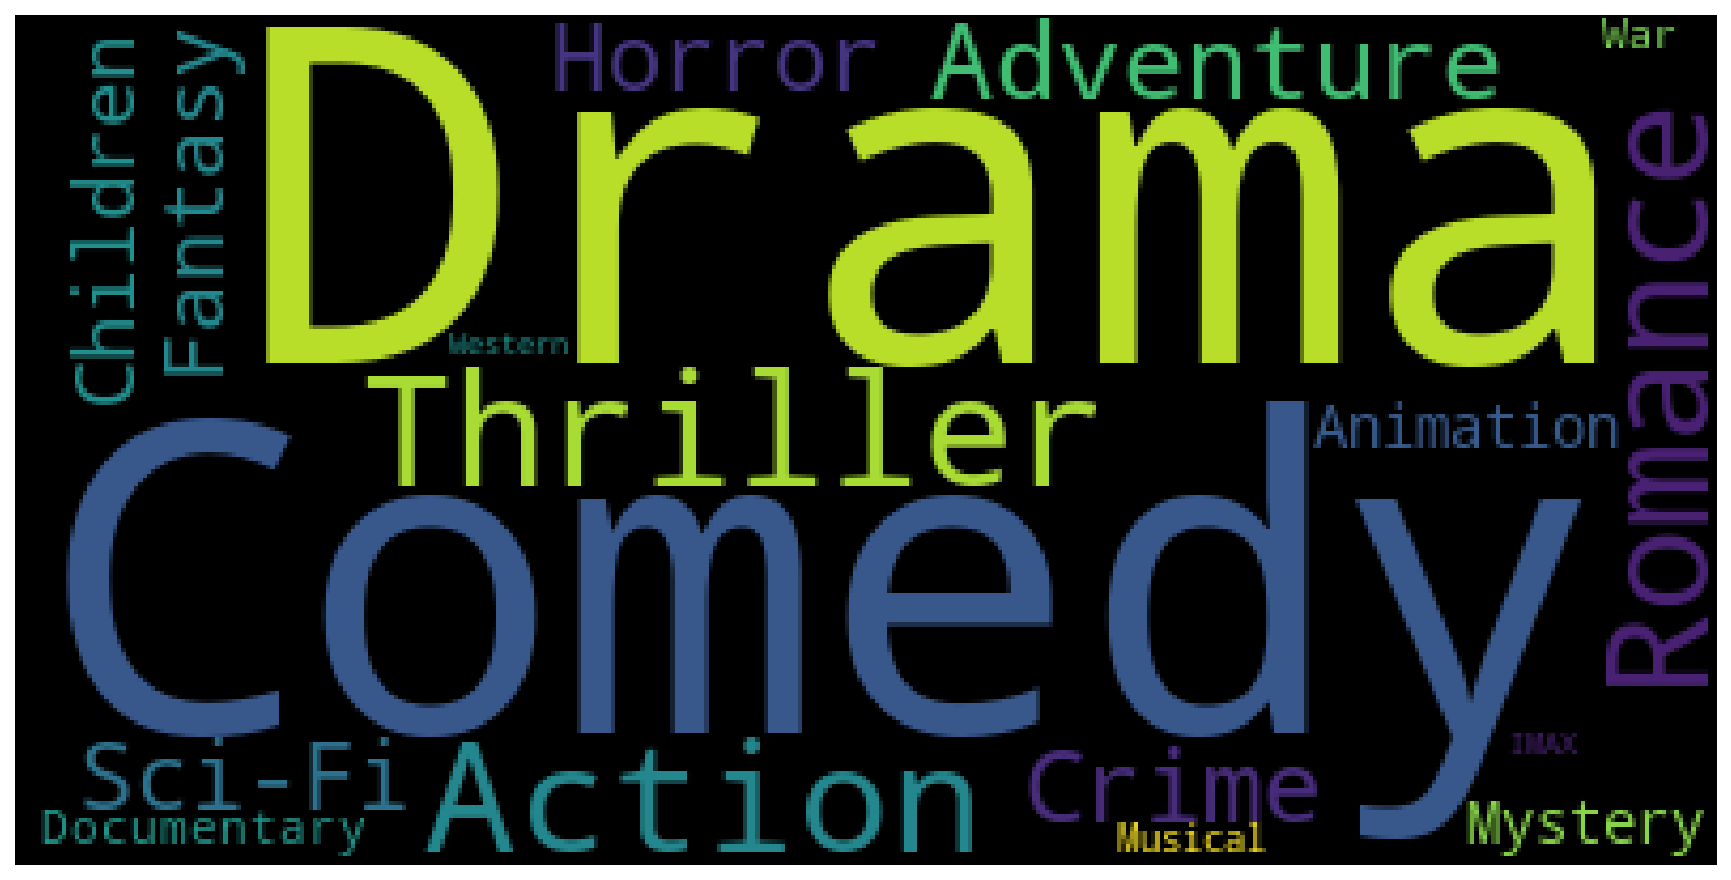

In [14]:
from wordcloud import WordCloud

wordcloud = WordCloud(width=400, height=200, background_color = 'black', min_font_size=7).generate_from_frequencies(genres)

plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### Heavily Rated Movies

In [15]:
df_combined.head()

,userId,movieId,rating,title,genres
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


In [16]:
# Let's group 'title' by 'rating' mean
df_n_ratings = pd.DataFrame(df_combined.groupby('title')['rating'].mean())

df_n_ratings.head()

,rating
title,
'71 (2014),4.0
'Hellboy': The Seeds of Creation (2004),4.0
'Round Midnight (1986),3.5
'Salem's Lot (2004),5.0
'Til There Was You (1997),4.0


In [17]:
# Create a new column 'total ratings'
df_n_ratings['total ratings'] = pd.DataFrame(df_combined.groupby('title')['rating'].count())

df_n_ratings.head()

,rating,total ratings
title,,
'71 (2014),4.0,1
'Hellboy': The Seeds of Creation (2004),4.0,1
'Round Midnight (1986),3.5,2
'Salem's Lot (2004),5.0,1
'Til There Was You (1997),4.0,2


In [18]:
# Rename 'rating' to 'mean ratings'
df_n_ratings.rename(columns = {'rating': 'mean ratings'}, inplace=True)

df_n_ratings.head()

,mean ratings,total ratings
title,,
'71 (2014),4.0,1
'Hellboy': The Seeds of Creation (2004),4.0,1
'Round Midnight (1986),3.5,2
'Salem's Lot (2004),5.0,1
'Til There Was You (1997),4.0,2


In [19]:
# Put in order by 'total ratings'
df_n_ratings.sort_values('total ratings', ascending=False).head(10)

,mean ratings,total ratings
title,,
Forrest Gump (1994),4.164134,329
"Shawshank Redemption, The (1994)",4.429022,317
Pulp Fiction (1994),4.197068,307
"Silence of the Lambs, The (1991)",4.161290,279
"Matrix, The (1999)",4.192446,278
Star Wars: Episode IV - A New Hope (1977),4.231076,251
Jurassic Park (1993),3.750000,238
Braveheart (1995),4.031646,237
Terminator 2: Judgment Day (1991),3.970982,224


Most of these movies stand among the Top 50 movies in the IMDB ratings even today.

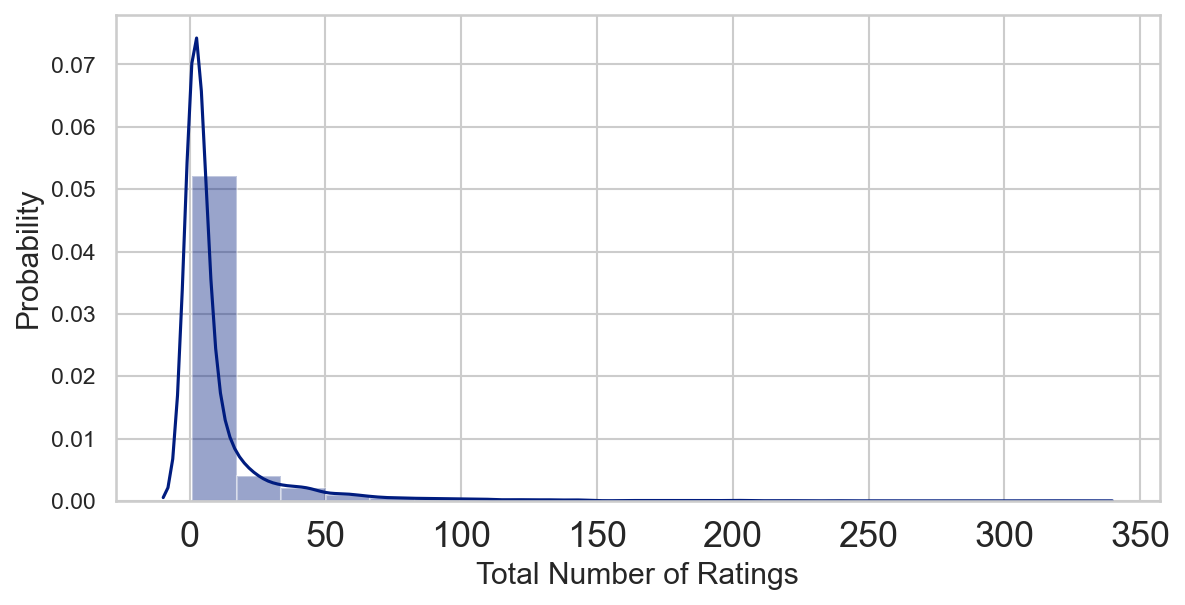

In [20]:
# Let's see the distribution

plt.figure(figsize=(8,4))
sns.distplot(df_n_ratings['total ratings'], bins=20)
plt.xlabel('Total Number of Ratings')
plt.ylabel('Probability')
plt.show()

Some observations:

* Majority of the movies have less than 50 ratings.
* The number of movies having more than 100 ratings is very low.

### Highly Rated Movies

In [21]:
# Put in order by 'mean ratings'
df_n_ratings.sort_values('mean ratings', ascending=False).head(10)

,mean ratings,total ratings
title,,
Gena the Crocodile (1969),5.0,1
True Stories (1986),5.0,1
Cosmic Scrat-tastrophe (2015),5.0,1
Love and Pigeons (1985),5.0,1
Red Sorghum (Hong gao liang) (1987),5.0,1
"Thin Line Between Love and Hate, A (1996)",5.0,1
Lesson Faust (1994),5.0,2
Eva (2011),5.0,1
Who Killed Chea Vichea? (2010),5.0,1


In [22]:
# Number of movies with 'mean ratings' = 5
print('Total no of users that gave rating of 5.0 : ', len(df_n_ratings.loc[df_n_ratings['mean ratings'] == 5]), '\n')

Total no of users that gave rating of 5.0 :  296 



In [23]:
# Number of movies that receive 5 stars and have only one rating
print('Total no of movies that receive 5.0 but receive just one rating: ', len(df_n_ratings.loc[(df_n_ratings['mean ratings'] == 5) 
                                                                           & (df_n_ratings['total ratings'] == 1)]))

Total no of movies that receive 5.0 but receive just one rating:  289


It would make a good recommendation system if we can use both the factors ( -> Highly Rated Movies & Heavily Rated Movies <- ) together.

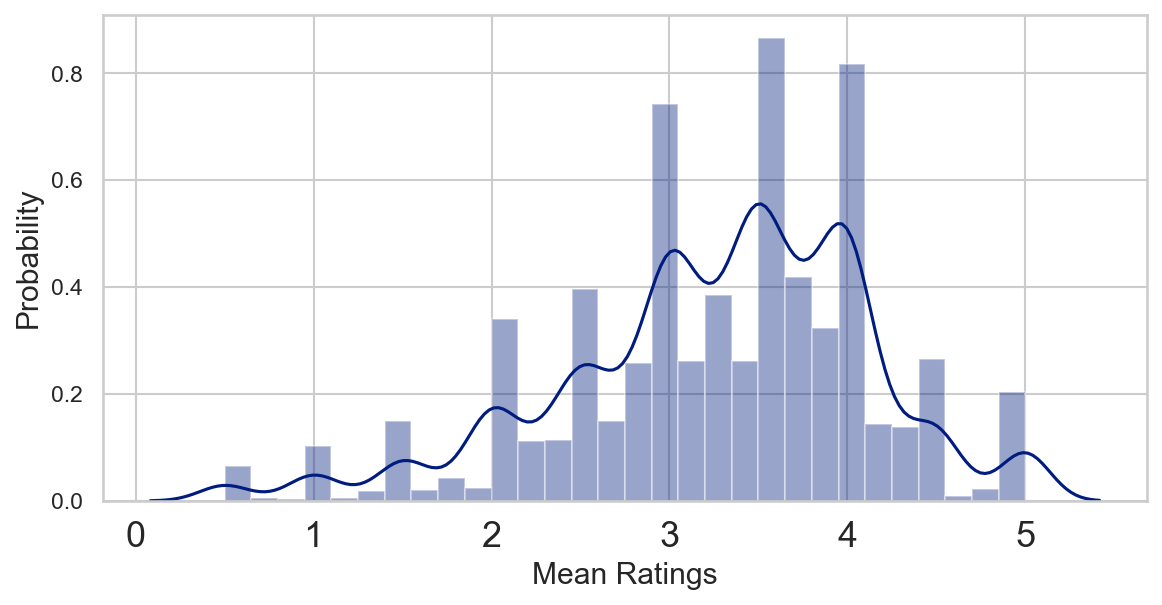

In [24]:
# Distribution of 'mean ratings'

plt.figure(figsize=(8,4))
sns.distplot(df_n_ratings['mean ratings'], bins=30)
plt.xlabel('Mean Ratings')
plt.ylabel('Probability')
plt.show()

### Mean Ratings vs Total Number of Ratings

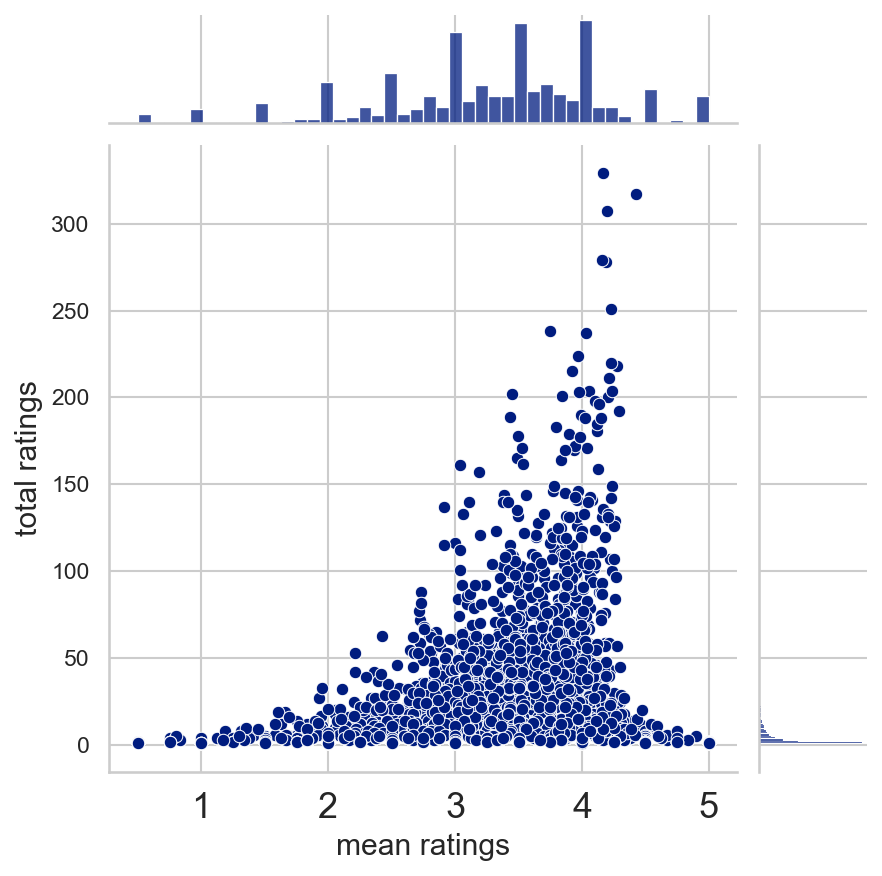

In [25]:
sns.jointplot(x = 'mean ratings', y = 'total ratings', data = df_n_ratings )

# Collaborative Filtering (CF)

*Collaborative filtering* is the process of filtering for information or patterns using techniques involving collaboration among multiple agents, viewpoints, data sources. Basically, it is a method of making automatic predictions (filtering) about the interests of a user by collecting preferences or taste information from many users.

There are 2 approaches to CF -->

**Memory-Based CF** - It is an approach which finds similarity between users or between items to recommend similar items. Examples include Neighbourhood-based CF and Item-based/User-based top-N recommendations.

**Model-Based CF** - In this approach we use different data mining, machine learning algorithms to predict users' rating of unrated items. Examples include Singular Value Decomposition (SVD) , Principal Component Analysis (PCA) etc.

### Create User-Item Matrix

In [26]:
df_combined.head()

,userId,movieId,rating,title,genres
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,"Usual Suspects, The (1995)",Crime|Mystery|Thriller


In [27]:
util_mat = df_combined.pivot_table(index = 'userId', columns = 'title', values = 'rating')

util_mat.head()

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### User Based Collaborative Filtering

In [28]:
user_util_matrix = util_mat.copy()

# We will fill the row wise NaN's with the corresponding user's mean ratings, so that we can carry out Pearson correlation.
# Here we assume avg ratings for the movie that is not rated.
user_util_matrix = user_util_matrix.apply(lambda row: row.fillna(row.mean()), axis=1)

user_util_matrix.head(5)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,4.366379,4.366379,4.366379,4.366379,4.366379,4.366379,4.366379,4.366379,4.366379,4.366379,...,4.366379,4.366379,4.366379,4.366379,4.366379,4.366379,4.366379,4.366379,4.000000,4.366379
2,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276,...,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276,3.948276
3,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897,...,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897,2.435897
4,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556,...,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556,3.555556
5,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364,...,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364,3.636364


In [29]:
# Correlation
user_util_matrix.T.corr()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
userId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,1.264516e-03,5.525772e-04,0.048419,0.021847,-0.045497,-6.199672e-03,0.047013,1.950985e-02,-8.754088e-03,...,0.018127,-0.017172,-0.015221,-3.705875e-02,-2.912138e-02,0.012016,0.055261,0.075224,-2.571255e-02,0.010932
2,0.001265,1.000000e+00,-4.975816e-17,-0.017164,0.021796,-0.021051,-1.111357e-02,-0.048085,7.652805e-16,3.011629e-03,...,-0.050551,-0.031581,-0.001688,-1.265569e-15,-6.430371e-16,0.006226,-0.020504,-0.006001,-6.009100e-02,0.024999
3,0.000553,-4.975816e-17,1.000000e+00,-0.011260,-0.031539,0.004800,-2.587070e-16,-0.032471,-4.812885e-16,3.774064e-16,...,-0.004904,-0.016117,0.017749,-8.106536e-16,-1.430628e-03,-0.037289,-0.007789,-0.013001,-1.168878e-16,0.019550
4,0.048419,-1.716402e-02,-1.125978e-02,1.000000,-0.029620,0.013956,5.809139e-02,0.002065,-5.873603e-03,5.159032e-02,...,-0.037687,0.063122,0.027640,-1.378212e-02,4.003747e-02,0.020590,0.014628,-0.037569,-1.788358e-02,-0.000995
5,0.021847,2.179571e-02,-3.153892e-02,-0.029620,1.000000,0.009111,1.011715e-02,-0.012284,7.750436e-16,-3.316512e-02,...,0.015964,0.012427,0.027076,1.246135e-02,-3.627206e-02,0.026319,0.031896,-0.001751,9.382892e-02,-0.000278
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0.012016,6.225827e-03,-3.728895e-02,0.020590,0.026319,-0.009137,2.832591e-02,0.022277,3.163273e-02,-3.994577e-02,...,0.053683,0.016384,0.098011,6.107833e-02,1.967830e-02,1.000000,0.017927,0.056676,3.842210e-02,0.075464
607,0.055261,-2.050374e-02,-7.789105e-03,0.014628,0.031896,0.045501,3.098070e-02,0.048822,-1.216061e-02,-1.765576e-02,...,0.049059,0.038197,0.049317,2.355180e-03,-2.938114e-02,0.017927,1.000000,0.044514,1.904919e-02,0.021860
608,0.075224,-6.000828e-03,-1.300064e-02,-0.037569,-0.001751,0.021727,2.841409e-02,0.071759,3.278284e-02,-5.199963e-02,...,0.069198,0.051388,0.012801,6.318649e-03,-7.977761e-03,0.056676,0.044514,1.000000,5.071449e-02,0.054454


In [30]:
# Let's save this matrix
user_corr_mat = user_util_matrix.T.corr()

# For convinience, we will be considering only the correlation of all users with the first user only
corr_user_1 = user_corr_mat.iloc[0]

corr_user_1

userId
1      1.000000
2      0.001265
3      0.000553
4      0.048419
5      0.021847
         ...   
606    0.012016
607    0.055261
608    0.075224
609   -0.025713
610    0.010932
Name: 1, Length: 610, dtype: float64

In [31]:
# Let's put it in order
corr_user_1.sort_values(ascending=False, inplace=True)

corr_user_1

userId
1      1.000000
301    0.124799
597    0.102631
414    0.101348
477    0.099217
         ...   
71    -0.082932
370   -0.086678
501   -0.090018
579   -0.105003
53          NaN
Name: 1, Length: 610, dtype: float64

In [32]:
# NaN values are generated in corr() as the std dev is zero, which is required in calculating Pearson Similarity.
corr_user_1.dropna(inplace = True)

# Let's create a list of top 50 users that has similiarity with User1
top50_corr_users = corr_user_1[1:51]  # Neglect the 1st corr value as it is user1 itself

We have list of all movies that user 1 has ever rated:

In [33]:
df_combined[ df_combined['userId'] == 1]

,userId,movieId,rating,title,genres
0,1,1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,Seven (a.k.a. Se7en) (1995),Mystery|Thriller
4,1,50,5.0,"Usual Suspects, The (1995)",Crime|Mystery|Thriller
...,...,...,...,...,...
227,1,3744,4.0,Shaft (2000),Action|Crime|Thriller
228,1,3793,5.0,X-Men (2000),Action|Adventure|Sci-Fi
229,1,3809,4.0,What About Bob? (1991),Comedy
230,1,4006,4.0,Transformers: The Movie (1986),Adventure|Animation|Children|Sci-Fi


In [34]:
# user1 has not rated 32 movie
df_combined[ (df_combined['userId'] == 1) & (df_combined['movieId'] == 32) ] 

,userId,movieId,rating,title,genres


In [35]:
print('32nd Movie : ', movies['title'][ movies['movieId'] == 32 ].values)

32nd Movie :  ['Twelve Monkeys (a.k.a. 12 Monkeys) (1995)']


So, let's calculate what ratings user 1 would give to the movie with the help of similarrity vector. And based on that rating, we can compare it with a threshold rating. If the rating is higher it will be visible to the active user in his/her recommended list.

In [36]:
df_n_ratings.loc[['Twelve Monkeys (a.k.a. 12 Monkeys) (1995)']]

,mean ratings,total ratings
title,,
Twelve Monkeys (a.k.a. 12 Monkeys) (1995),3.983051,177


In [37]:
top50_users = top50_corr_users.keys()

count = 0
users = list()
for user in top50_users:
    if df_combined[ (df_combined['userId'] == user) & (df_combined['movieId'] == 32) ]['rating'].sum()  :
        count +=1
        users.append(user)

print(count)

30


There are 30 similar users among the Top-50 similar users that have rated the movie "The Twelve Monkeys".

* Now, let's calculate the rating user 1 would give to the movie,

* Predicted rating = sum of [ (weights) * (ratings) ] / sum of (weights)

Here, weights is the correlation of the corresponding user with the first user.

In [38]:
# Let's define a function to calculate what user1 will rate the movie
# We use Weighted average of k similar users

def predict_rating():
    
    sum_similarity = 0
    weighted_ratings = 0

    for user in users:
        
        weighted_ratings += top50_corr_users.loc[user] * df_combined[(df_combined['userId'] == user) & (df_combined['movieId'] == 32)]['rating'].sum()
        sum_similarity += top50_corr_users.loc[user]

    print(weighted_ratings / sum_similarity)

In [39]:
df_m[ df_m['movieId'] == 32]

,movieId,title,genres
31,32,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller


Well there are pretty good changes of recommending this movie movie to the 1st user, since the rating is quite good.

So, this is how a naive User-based CF works. Predicted ratings are calculated similarly for every user, (obviously for the movies he's not rated) and depending upon the threshold rating, the movie is either displayed on his recommended list or discarded.

# Item Based Collaborative Filtering

Let's find similar movies to jurassic Park

In [40]:
# The 'Jurassic Park' case
df_n_ratings.loc[['Jurassic Park (1993)']]

,mean ratings,total ratings
title,,
Jurassic Park (1993),3.75,238


In [41]:
item_util_matrix = util_mat.copy()

item_util_matrix.head(10)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN


In [42]:
# We will fill the column wise NaN's with the corresponding movie's mean ratings, so that we can carry out Pearson correlation.
# Here we assume avg ratings for the user that has not a rated movie.

item_util_matrix = item_util_matrix.apply(lambda col : col.fillna(col.mean()), axis=0)

item_util_matrix.head(5)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,4.0,4.0,3.5,5.0,4.0,1.5,3.176471,3.0,3.666667,3.285714,...,1.5,4.0625,3.666667,3.0,3.0,3.863636,2.770833,2.0,4.000000,1.0
2,4.0,4.0,3.5,5.0,4.0,1.5,3.176471,3.0,3.666667,3.285714,...,1.5,4.0625,3.666667,3.0,3.0,3.863636,2.770833,2.0,3.134615,1.0
3,4.0,4.0,3.5,5.0,4.0,1.5,3.176471,3.0,3.666667,3.285714,...,1.5,4.0625,3.666667,3.0,3.0,3.863636,2.770833,2.0,3.134615,1.0
4,4.0,4.0,3.5,5.0,4.0,1.5,3.176471,3.0,3.666667,3.285714,...,1.5,4.0625,3.666667,3.0,3.0,3.863636,2.770833,2.0,3.134615,1.0
5,4.0,4.0,3.5,5.0,4.0,1.5,3.176471,3.0,3.666667,3.285714,...,1.5,4.0625,3.666667,3.0,3.0,3.863636,2.770833,2.0,3.134615,1.0


In [43]:
item_util_matrix.isna().sum()

title
'71 (2014)                                   0
'Hellboy': The Seeds of Creation (2004)      0
'Round Midnight (1986)                       0
'Salem's Lot (2004)                          0
'Til There Was You (1997)                    0
                                            ..
eXistenZ (1999)                              0
xXx (2002)                                   0
xXx: State of the Union (2005)               0
¡Three Amigos! (1986)                        0
À nous la liberté (Freedom for Us) (1931)    0
Length: 9719, dtype: int64

In [44]:
item_util_matrix.isna().sum().sum()

0

This guarantees that every movie is rated by at least one user.

In [45]:
item_util_matrix.corr()

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
title,,,,,,,,,,,,,,,,,,,,,
'71 (2014),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Hellboy': The Seeds of Creation (2004),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Round Midnight (1986),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Salem's Lot (2004),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
'Til There Was You (1997),NaN,NaN,NaN,NaN,1.000000e+00,NaN,-2.470228e-17,NaN,-6.783236e-16,-4.090781e-16,...,NaN,1.491400e-15,-2.970631e-18,NaN,NaN,-1.174172e-16,-4.643126e-16,-1.457468e-15,2.901144e-15,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
eXistenZ (1999),NaN,NaN,NaN,NaN,-1.174172e-16,NaN,6.069910e-02,NaN,-7.527708e-02,2.947366e-02,...,NaN,-1.447002e-15,-3.196632e-16,NaN,NaN,1.000000e+00,3.784587e-02,1.243849e-15,-3.410933e-02,NaN
xXx (2002),NaN,NaN,NaN,NaN,-4.643126e-16,NaN,-3.527098e-03,NaN,1.558884e-01,2.511177e-01,...,NaN,-2.067568e-01,-4.854206e-03,NaN,NaN,3.784587e-02,1.000000e+00,2.449296e-01,1.854832e-02,NaN
xXx: State of the Union (2005),NaN,NaN,NaN,NaN,-1.457468e-15,NaN,6.027298e-16,NaN,1.107823e-01,-1.311693e-15,...,NaN,-2.014024e-01,7.715167e-02,NaN,NaN,1.243849e-15,2.449296e-01,1.000000e+00,1.034849e-15,NaN


* There are lot of NaN values and that is because when we are calculating the Pearson correlation, if the rating vector has all the values same for eg -> [3.0 , 3.0, 3.0, 3.0, ....], then the Standard Deviation is zero and division by zero is undefined, and thus its correlation with any other rating vector is NaN.

* Since there are many movies that are rated only by 1 user , there the whole column mean is filled with the rating of that user, and therefore it's Pearson correlation gives NaN values with any other column.

In [46]:
# Save this matrix
item_corr_matrix = item_util_matrix.corr()

# Apply this movie in the matrix
jurassic_park_corr = item_corr_matrix['Jurassic Park (1993)']

jurassic_park_corr

title
'71 (2014)                                            NaN
'Hellboy': The Seeds of Creation (2004)               NaN
'Round Midnight (1986)                                NaN
'Salem's Lot (2004)                                   NaN
'Til There Was You (1997)                   -6.043681e-16
                                                 ...     
eXistenZ (1999)                              7.374123e-02
xXx (2002)                                  -1.186059e-02
xXx: State of the Union (2005)              -1.044262e-01
¡Three Amigos! (1986)                        5.376280e-02
À nous la liberté (Freedom for Us) (1931)             NaN
Name: Jurassic Park (1993), Length: 9719, dtype: float64

In [47]:
# Drop NaN
jurassic_park_corr.dropna(inplace=True)

# Put this list in order
jurassic_park_corr = jurassic_park_corr.sort_values(ascending=False)

jurassic_park_corr

title
Jurassic Park (1993)                    1.000000
Fugitive, The (1993)                    0.324717
Lethal Weapon (1987)                    0.318646
Independence Day (a.k.a. ID4) (1996)    0.263629
Mission: Impossible (1996)              0.258080
                                          ...   
Machete Kills (Machete 2) (2013)       -0.161106
Cyrano de Bergerac (1990)              -0.167715
Ready Player One                       -0.170527
Miss Potter (2006)                     -0.187958
Polar Express, The (2004)              -0.215130
Name: Jurassic Park (1993), Length: 5980, dtype: float64

In [48]:
movies_similar_to_jurassic_park = pd.DataFrame(data=jurassic_park_corr.values, columns=['Correlation'], 
                                               index = jurassic_park_corr.index)

movies_similar_to_jurassic_park.head()

,Correlation
title,
Jurassic Park (1993),1.000000
"Fugitive, The (1993)",0.324717
Lethal Weapon (1987),0.318646
Independence Day (a.k.a. ID4) (1996),0.263629
Mission: Impossible (1996),0.258080


In [49]:
movies_similar_to_jurassic_park = movies_similar_to_jurassic_park.join(df_n_ratings['total ratings'])

movies_similar_to_jurassic_park.head(10)

,Correlation,total ratings
title,,
Jurassic Park (1993),1.000000,238
"Fugitive, The (1993)",0.324717,190
Lethal Weapon (1987),0.318646,75
Independence Day (a.k.a. ID4) (1996),0.263629,202
Mission: Impossible (1996),0.258080,162
Ghostbusters (a.k.a. Ghost Busters) (1984),0.256527,120
Mulan (1998),0.255672,45
Rise of the Planet of the Apes (2011),0.248134,27
"Bug's Life, A (1998)",0.240964,92


In [50]:
# Exclude the First Element
movies_similar_to_jurassic_park = movies_similar_to_jurassic_park[1:]

# Select only movies with more than 100 'total rating', and put in the order based on 'Correlation'
movies_similar_to_jurassic_park[movies_similar_to_jurassic_park['total ratings'] > 100 ].sort_values(ascending=False,
                                                                                          by=['Correlation']).head(10)

,Correlation,total ratings
title,,
"Fugitive, The (1993)",0.324717,190
Independence Day (a.k.a. ID4) (1996),0.263629,202
Mission: Impossible (1996),0.258080,162
Ghostbusters (a.k.a. Ghost Busters) (1984),0.256527,120
Indiana Jones and the Temple of Doom (1984),0.239826,108
Die Hard (1988),0.239294,145
Aladdin (1992),0.227711,183
Braveheart (1995),0.222085,237
Speed (1994),0.220720,171


# Model Based Collaborative Filtering

Model-based methods are based on matrix factorization and are better at dealing with sparsity.

* We will be using a "Surprise" library to implement SVD, KNN and NMF.
* You can find its documentation here > https://surprise.readthedocs.io/en/stable/
* Surprise Library has almost all the algorithms implemented that are required for model-based Recommendation systems.

In [51]:
from surprise import Reader, Dataset, KNNBasic, SVD, NMF
from surprise.model_selection import GridSearchCV, cross_validate

To load a dataset from a pandas dataframe, you will need the `load_from_df()` method. You will also need a Reader object, but only the `rating_scale` parameter must be specified.

The `Reader` class is used to parse a file containing ratings.

In [52]:
reader = Reader(rating_scale=(0.5, 5.0))

data = Dataset.load_from_df( ratings[['userId', 'movieId', 'rating']], reader = reader )

### K-Nearest Neighbours (KNN)

In [53]:
# Compute Mean Squared Distance Similarity

sim_options = {'name' : 'msd'}

algo = KNNBasic(k=20, sim_options=sim_options )

cross_validate(algo=algo, data=data, measures=['RMSE'], cv=5, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Evaluating RMSE of algorithm KNNBasic on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9434  0.9401  0.9332  0.9430  0.9451  0.9410  0.0042  
Fit time          0.24    0.25    0.26    0.21    0.25    0.24    0.02    
Test time         1.25    1.37    1.32    1.44    1.29    1.33    0.07    


{'test_rmse': array([0.943373  , 0.94007333, 0.93317833, 0.94302411, 0.94511475]),
 'fit_time': (0.23556995391845703,
  0.2532775402069092,
  0.2588493824005127,
  0.20533514022827148,
  0.2500569820404053),
 'test_time': (1.2478044033050537,
  1.374330997467041,
  1.320425271987915,
  1.4364268779754639,
  1.294126033782959)}

##### Tuning KNN using GridSearchCV

In [54]:
n_neighbours = [10, 20, 30]
param_grid = {'n_neighbours' : n_neighbours}

gs = GridSearchCV(KNNBasic, measures=['RMSE'], param_grid=param_grid)
gs.fit(data)

print('\n\n###############')
# Best RMSE score
print('Best Score :', gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print('Best Parameters :', gs.best_params['rmse'])
print('###############')

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computi

### Singular Value Decomposition (SVD)

In [55]:
algo = SVD()
cross_validate(algo=algo, data=data, measures=['RMSE'], cv=5, verbose=True)

Evaluating RMSE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.8781  0.8800  0.8752  0.8707  0.8670  0.8742  0.0048  
Fit time          1.38    1.33    1.36    1.41    1.38    1.37    0.03    
Test time         0.19    0.23    0.31    0.26    0.21    0.24    0.04    


{'test_rmse': array([0.87806203, 0.87996124, 0.87524341, 0.87072867, 0.86695018]),
 'fit_time': (1.3799529075622559,
  1.3255269527435303,
  1.3593218326568604,
  1.4052152633666992,
  1.3832640647888184),
 'test_time': (0.18641042709350586,
  0.22691607475280762,
  0.3115377426147461,
  0.26497888565063477,
  0.20635294914245605)}

##### Fine Tuning SVD using GridSearchCV

[Click here to view the parameters](https://surprise.readthedocs.io/en/stable/matrix_factorization.html)

In [56]:
param_grid = {'n_factors' : [50, 75], 'lr_all' : [0.5, 0.05], 'reg_all' : [0.06, 0.04]}

gs = GridSearchCV(algo_class=SVD, measures=['RMSE'], param_grid=param_grid)
gs.fit(data)

print('\n###############')
# Best RMSE score
print('Best Score :', gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print('Best Parameters :', gs.best_params['rmse'])
print('###############')


###############
Best Score : 0.8653346637171871
Best Parameters : {'n_factors': 75, 'lr_all': 0.05, 'reg_all': 0.06}
###############


### Non-Negative Matrix Factorization (NMF)

In [57]:
algo = NMF()
cross_validate(data=data, algo=algo, measures=['RMSE'], cv=5, verbose=True)

Evaluating RMSE of algorithm NMF on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9171  0.9316  0.9237  0.9219  0.9219  0.9232  0.0047  
Fit time          2.71    2.60    2.73    3.04    2.77    2.77    0.14    
Test time         0.20    0.29    0.17    0.33    0.18    0.23    0.06    


{'test_rmse': array([0.9170642 , 0.93160615, 0.92371358, 0.92185385, 0.92188489]),
 'fit_time': (2.714536428451538,
  2.6020827293395996,
  2.731757879257202,
  3.0370631217956543,
  2.772648811340332),
 'test_time': (0.1989154815673828,
  0.2920656204223633,
  0.1728518009185791,
  0.32731080055236816,
  0.18085050582885742)}

##### Fine-Tune NMF using GridSearchCV

In [58]:
# Fine-tuning NMF
param_grid = {
    'n_factors': [10, 20, 30], 
    'n_epochs': [50, 100], 
    'reg_pu': [0.06, 0.04], 
    'reg_qi': [0.06, 0.04]
}

gs = GridSearchCV(algo_class=NMF, measures=['RMSE'], param_grid=param_grid)
gs.fit(data)

print('\n###############')
# Best RMSE score
print('Best Score:', gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print('Best Parameters:', gs.best_params['rmse'])
print('###############')


###############
Best Score: 0.9115378024098426
Best Parameters: {'n_factors': 30, 'n_epochs': 100, 'reg_pu': 0.06, 'reg_qi': 0.06}
###############
